# Getting Familiar with The Data


## **Reading Data From Drive**

In [ ]:
# Code to read file into Colaboratory:
! pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1RvZn7S66cSj_tCQRUnJJCSt78SaAda9_/view?usp=sharing' # The shareable link
# to get the id part of the file
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('IMDB Dataset.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Imports**

In [ ]:
import pandas as pd
import numpy as np
import io
from sklearn.model_selection import train_test_split
import torch 
import torch.nn.functional as F
from torch import flatten
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch import nn
import time
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

## **Adjusting the Data format**

In [ ]:
dataframe = pd.read_csv('IMDB Dataset.csv')

In [ ]:
print(np.unique(np.array(dataframe.iloc[:, 1]), return_counts=True))

(array(['negative', 'positive'], dtype=object), array([25000, 25000]))


**Splitting Data**

In [ ]:
data, labels = dataframe.iloc[:, :-1], dataframe.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=0.7, stratify=labels)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=(2/3), stratify=y_test)

In [ ]:
print(np.unique(y_test, return_counts=True))
print(np.unique(y_validation, return_counts=True))
print(np.unique(y_train, return_counts=True))

(array(['negative', 'positive'], dtype=object), array([5000, 5000]))
(array(['negative', 'positive'], dtype=object), array([2500, 2500]))
(array(['negative', 'positive'], dtype=object), array([17500, 17500]))


In [ ]:
x_train2 = np.array(x_train).squeeze(1)
y_train2 = np.array(y_train)
x_test2 = np.array(x_test).squeeze(1)
y_test2 = np.array(y_test)
x_validation2 = np.array(x_validation).squeeze(1)
y_validation2 = np.array(y_validation)

In [ ]:
def toNumbers(dataset):
  for i in range(len(dataset)):
    if dataset[i] == 'positive': dataset[i] = 1.
    else: dataset[i] = 0.
  return dataset.astype(float)

# Classification Using BERT

## **Model**

In [ ]:
class ModifiedBERT(nn.Module):
 def __init__(self):
    super(ModifiedBERT, self).__init__()
    
    self.fc1 = nn.Linear(in_features=768, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=128)
    self.fc4 = nn.Linear(in_features=128, out_features=64)
    self.fc5 = nn.Linear(in_features=64, out_features=1)
    self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions = False, output_hidden_states = False) 


 def forward(self, input_ids, input_masks):
    x = self.bert(input_ids, token_type_ids=None, attention_mask=input_masks)[1]
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.dropout(x, 0.4)
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))

    return F.sigmoid(self.fc5(x))

## **Dataset Class**

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, inputIDs, attentionMasks, labels):
        self.labels = labels
        self.dict_labels = {'negative': 0, 'positive': 1}
        self.attentionMasks = attentionMasks
        self.inputIDs = inputIDs

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        inputID = torch.tensor(self.inputIDs[index])
        attentionMask = torch.tensor(self.attentionMasks[index])
        label = torch.tensor(self.labels[index])
        return inputID, attentionMask, label

## **Methods**

In [ ]:
def tvt(optimizer, mode, model, dataloader):
  if mode == 'train':
    model.train()
    numberOfBatches = trainNumOfBatches
  elif mode == 'validation':
    model.eval()
    numberOfBatches = valNumOfBatches
  else:
    model.eval()
    predictedLabels = []
  batchNumber = 1
  totalLoss = 0
  correctPred = 0
  counter = 0
  lossFn = nn.BCELoss()
  # lossFn = nn.BCEWithLogitsLoss()
  for (input_ids, input_mask, labels) in dataloader:

        (input_ids, input_mask, labels) = (input_ids.to(device), input_mask.to(device), labels.to(device))

        pred = model(input_ids, input_mask)
        counter += 1
        if mode != 'test':
          pred = pred.squeeze(1)
          pred.cpu()
          temp = pred.cpu().detach().numpy().copy()

          for i in range(len(pred)):
            temp[i] = 0. if temp[i] <= 0.5 else 1.
          loss = lossFn(pred, labels.float())
          totalLoss += loss
          compare = [1 if i==j else 0 for i, j in zip(temp,labels)]
          correctPred += np.array(compare).sum()
        if mode == 'train':
          optimizer.zero_grad() 
          loss.backward()  
          optimizer.step()
        if mode == 'test':
          temp = pred.cpu().detach().numpy().copy()
          for i in range(len(pred)):
            temp[i] = 0. if temp[i] <= 0.5 else 1.
          predictedLabels.extend(temp)
          correctPred = predictedLabels
        
        del input_ids
        del input_mask
        del labels
        torch.cuda.empty_cache()
        batchNumber += 1

  return totalLoss/len(dataloader), correctPred

In [ ]:
def getTokenizedData(dataset, tokenizer):
  input_ids = []
  attention_masks = []

  for sentence in dataset:
      encoded_dict = tokenizer.encode_plus(
                          sentence,                      
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 512,          
                          pad_to_max_length = True,   # Pad & truncate all sentences.
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      input_ids.append(encoded_dict['input_ids'])
      attention_masks.append(encoded_dict['attention_mask'])
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  return input_ids, attention_masks

In [ ]:
def Plotting(trainLoss,trainAcc, validationLoss, validationAcc):
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig2 = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(go.Scatter(y=validationLoss, name="Validation Loss"), secondary_y=False)
    fig.add_trace(go.Scatter(y=trainLoss, name="Training Loss"), secondary_y=False)
    fig2.add_trace(go.Scatter(y=validationAcc, name="Validation Accuracy"), secondary_y=False)
    fig2.add_trace(go.Scatter(y=trainAcc, name="Training Accuracy"), secondary_y=False)

    # Add figure title
    fig.update_layout(title_text="Loss of Model")
    fig2.update_layout(title_text="Accuracy of Model")

    # Set x-axis title
    fig.update_xaxes(title_text="Epoch")
    fig.update_yaxes(title_text="Loss")
    fig2.update_xaxes(title_text="Epoch")
    fig2.update_yaxes(title_text="Accuracy")
    fig.show()
    fig2.show()
    return

In [ ]:
def plotting_learning_rates(list1,list2,list3,list4,lr1,lr2,lr3,lr4):
  plt.figure(figsize=(12, 6))
  plt.plot(list1, color='red')
  plt.plot(list2, color='blue')
  plt.plot(list3, color='green')
  plt.plot(list4, color='black')
  plt.legend([lr1, lr2,lr3,lr4], loc ="lower right")
  plt.title('Validation Accuracy For Different Learning Rates')
  plt.xlabel('Epochs')
  plt.ylabel('Validation Accuracy')

In [ ]:
def weights_init(m):
    for name, layer in m.named_modules(): 
      if isinstance(layer, torch.nn.Linear):           
          torch.nn.init.xavier_uniform_(layer.weight)
          # torch.nn.init.xavier_normal_(layer.weight)
          # torch.nn.init.kaiming_normal_(layer.weight)
          # torch.nn.init.kaiming_uniform_(layer.weight)

## **Saving and Loading Data**

In [ ]:
np.save("/content/gdrive/MyDrive/IMDB/validationInputID.npy", inputIdsValidation)
np.save("/content/gdrive/MyDrive/IMDB/validationAM.npy", AMValidation)
np.save("/content/gdrive/MyDrive/IMDB/validationLabels.npy", y_validation2)
np.save("/content/gdrive/MyDrive/IMDB/trainInputID.npy", inputIdsTrain)
np.save("/content/gdrive/MyDrive/IMDB/trainAM", AMTrain)
np.save("/content/gdrive/MyDrive/IMDB/trainLabels", y_train2)
np.save("/content/gdrive/MyDrive/IMDB/testInputID.npy", inputIdsTest)
np.save("/content/gdrive/MyDrive/IMDB/testAM", AMTest)
np.save("/content/gdrive/MyDrive/IMDB/testLabels", y_test2)

In [ ]:
inputIdsValidation = np.load("/content/gdrive/MyDrive/IMDB/Original/input_ids_validation.npy", allow_pickle=True)
AMValidation = np.load("/content/gdrive/MyDrive/IMDB/Original/attention_mask_validation.npy", allow_pickle=True)
y_validation2 = np.load("/content/gdrive/MyDrive/IMDB/Labels/validation.npy", allow_pickle=True)
inputIdsTrain = np.load("/content/gdrive/MyDrive/IMDB/Original/input_ids_train.npy", allow_pickle=True)
AMTrain = np.load("/content/gdrive/MyDrive/IMDB/Original/attention_mask_train.npy", allow_pickle=True)
y_train2 = np.load("/content/gdrive/MyDrive/IMDB/Labels/train.npy", allow_pickle=True)
inputIdsTest = np.load("/content/gdrive/MyDrive/IMDB/Original/input_ids_test.npy", allow_pickle=True)
AMTest = np.load("/content/gdrive/MyDrive/IMDB/Original/attention_mask_test.npy", allow_pickle=True)
y_test2 = np.load("/content/gdrive/MyDrive/IMDB/Labels/test.npy", allow_pickle=True)

## **Data Adjustment for Training and Testing**

**Tokenizer**

In [ ]:
!pip install transformers
from transformers import BertConfig, BertTokenizer
from torch.utils.data import TensorDataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 16.4 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
     |████████████████████████████████| 596 kB 67.7 MB/s 
     |████████████████████████████████| 6.6 MB 54.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Data Input IDs and Attention Masks**

In [ ]:
inputIdsValidation, AMValidation = getTokenizedData(x_validation2, tokenizer)
inputIdsTrain, AMTrain = getTokenizedData(x_train2, tokenizer)
inputIdsTest, AMTest = getTokenizedData(x_test2, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


**Dataloader and Optimizer Setup**

In [ ]:
from transformers import BertModel

In [ ]:
validation_data = IMDBDataset(inputIdsValidation, AMValidation, y_validation2)
training_data = IMDBDataset(inputIdsTrain, AMTrain, y_train2)
testing_data = IMDBDataset(inputIdsTest, AMTest, y_test2)

INIT_LR = 1e-6
BATCH_SIZE = 16
EPOCHS = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainDataLoader = DataLoader(training_data, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(validation_data, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testing_data, batch_size=BATCH_SIZE)

trainNumOfBatches = len(trainDataLoader.dataset) // BATCH_SIZE
valNumOfBatches = len(valDataLoader.dataset) // BATCH_SIZE

In [ ]:
model = ModifiedBERT()
model.to(device)
model.apply(weights_init)
opt = Adam(model.parameters(), lr=INIT_LR, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=0, factor=.1, threshold=1e-4, verbose=True)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## **Training & Testing**

### Learning Rate = 10^-6

**Training & Validation**

In [ ]:
trainLoss = []
validationLoss = []
trainAcc = []
validationAcc = []
PATH = '/content/gdrive/MyDrive/IMDB/Models/FirstModel_6LR_5Epochs.pt'

print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  trainLoss.append(avgTrainLoss.item()*100)
  trainAcc.append(correctPred/len(trainDataLoader.dataset))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    validationLoss.append(avgValLoss.item()*100)
    validationAcc.append(correctPred/len(valDataLoader.dataset))
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  # scheduler.step(avgValLoss)
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/TrainAcc_6LR_5Epochs", np.array(trainAcc))
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/ValLoss_6LR_5Epochs", np.array(validationLoss))
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/TrainLoss_6LR_5Epochs", np.array(trainLoss))
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/ValAcc_6LR_5Epochs", np.array(validationAcc))

  torch.save(model.state_dict(), PATH)
Plotting(trainLoss,trainAcc, validationLoss, validationAcc)



Training Model
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss: 0.617359, Train accuracy: 0.7465
Validation loss: 0.471626, Validation accuracy: 0.9090
Epoch 2/5
Train loss: 0.325372, Train accuracy: 0.9241
Validation loss: 0.248540, Validation accuracy: 0.9224
Epoch 3/5
Train loss: 0.206358, Train accuracy: 0.9355
Validation loss: 0.224174, Validation accuracy: 0.9240
Epoch 4/5
Train loss: 0.174626, Train accuracy: 0.9439
Validation loss: 0.208682, Validation accuracy: 0.9298
Epoch 5/5
Train loss: 0.157834, Train accuracy: 0.9495
Validation loss: 0.202526, Validation accuracy: 0.9292


**Testing**

In [ ]:
PATH = '/content/gdrive/MyDrive/IMDB/Models/FirstModel_6LR_5Epochs.pt'
model.load_state_dict(torch.load(PATH, map_location= torch.device('cpu')))

<All keys matched successfully>


Testing:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93      5000
         1.0       0.94      0.92      0.93      5000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



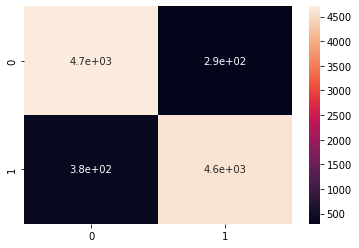

In [ ]:
with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  confusionMatrix = confusion_matrix(np.array(testing_data.labels), np.array(predections))
  print(classification_report(np.array(testing_data.labels), np.array(predections)))
  df = pd.DataFrame(confusionMatrix)
  sns.heatmap(df, annot=True)

**Saving The Model**

In [ ]:
# PATH = '/content/gdrive/MyDrive/IMDB/Models/.pt'
# torch.save(model.state_dict(), PATH)

# Additional Learning Rates

## Learning Rate = 10^-5

### **Dataloader and Optimizer Setup**

In [ ]:
from transformers import BertModel

In [ ]:
validation_data = IMDBDataset(inputIdsValidation, AMValidation, y_validation2)
training_data = IMDBDataset(inputIdsTrain, AMTrain, y_train2)
testing_data = IMDBDataset(inputIdsTest, AMTest, y_test2)

INIT_LR = 1e-5
BATCH_SIZE = 16
EPOCHS = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainDataLoader = DataLoader(training_data, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(validation_data, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testing_data, batch_size=BATCH_SIZE)

trainNumOfBatches = len(trainDataLoader.dataset) // BATCH_SIZE
valNumOfBatches = len(valDataLoader.dataset) // BATCH_SIZE

In [ ]:
model = ModifiedBERT()
model.apply(weights_init)
model.to(device)
opt = Adam(model.parameters(), lr=INIT_LR, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=0, factor=.1, threshold=1e-4, verbose=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### **Training & Testing**

**Training & Validation**

In [ ]:
trainLoss = []
validationLoss = []
trainAcc = []
validationAcc = []
PATH = '/content/gdrive/MyDrive/IMDB/Models/FirstModel_5LR_5Epochs.pt'

print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  trainLoss.append(avgTrainLoss.item()*100)
  trainAcc.append(correctPred/len(trainDataLoader.dataset))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    validationLoss.append(avgValLoss.item()*100)
    validationAcc.append(correctPred/len(valDataLoader.dataset))
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  # scheduler.step(avgValLoss)
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/TrainAcc_5LR_5Epochs", np.array(trainAcc))
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/ValLoss_5LR_5Epochs", np.array(validationLoss))
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/TrainLoss_5LR_5Epochs", np.array(trainLoss))
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/ValAcc_5LR_5Epochs", np.array(validationAcc))

  torch.save(model.state_dict(), PATH)
Plotting(trainLoss,trainAcc, validationLoss, validationAcc)



Training Model
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss: 0.266453, Train accuracy: 0.9009
Validation loss: 0.198845, Validation accuracy: 0.9286
Epoch 2/5
Train loss: 0.128269, Train accuracy: 0.9548
Validation loss: 0.169694, Validation accuracy: 0.9398
Epoch 3/5
Train loss: 0.073353, Train accuracy: 0.9771
Validation loss: 0.190341, Validation accuracy: 0.9424
Epoch 4/5
Train loss: 0.044607, Train accuracy: 0.9871
Validation loss: 0.219813, Validation accuracy: 0.9410
Epoch 5/5
Train loss: 0.032307, Train accuracy: 0.9912
Validation loss: 0.237430, Validation accuracy: 0.9358


**Testing**

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      5000
         1.0       0.96      0.92      0.94      5000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



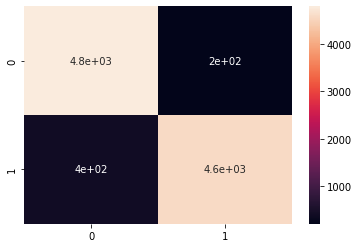

In [ ]:
with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  confusionMatrix = confusion_matrix(np.array(testing_data.labels), np.array(predections))
  print(classification_report(np.array(testing_data.labels), np.array(predections)))
  df = pd.DataFrame(confusionMatrix)
  sns.heatmap(df, annot=True)

## Learning Rate = 10^-4

### **Dataloader and Optimizer Setup**

In [ ]:
from transformers import BertModel

In [ ]:
validation_data = IMDBDataset(inputIdsValidation, AMValidation, y_validation2)
training_data = IMDBDataset(inputIdsTrain, AMTrain, y_train2)
testing_data = IMDBDataset(inputIdsTest, AMTest, y_test2)

INIT_LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainDataLoader = DataLoader(training_data, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(validation_data, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testing_data, batch_size=BATCH_SIZE)

trainNumOfBatches = len(trainDataLoader.dataset) // BATCH_SIZE
valNumOfBatches = len(valDataLoader.dataset) // BATCH_SIZE

In [ ]:
PATH = '/content/gdrive/MyDrive/IMDB/Models/MODFirstModel_4LR_5Epochs.pt'
model = ModifiedBERT()
model.load_state_dict(torch.load(PATH))
model.to(device)
opt = Adam(model.parameters(), lr=INIT_LR, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=0, factor=.1, threshold=1e-4, verbose=True)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### **Training & Testing**

**Training & Validation**

In [ ]:
trainLoss = np.load("/content/gdrive/MyDrive/IMDB/Validation Acc/MODTrainLoss_4LR_5Epochs.npy")
validationLoss = np.load("/content/gdrive/MyDrive/IMDB/Validation Acc/MODValLoss_4LR_5Epochs.npy")
trainAcc = np.load("/content/gdrive/MyDrive/IMDB/Validation Acc/MODTrainAcc_4LR_5Epochs.npy")
validationAcc = np.load("/content/gdrive/MyDrive/IMDB/Validation Acc/MODValAcc_4LR_5Epochs.npy")

for e in range(4,5):
  print('Epoch {0}/{1}'.format(e+1,5))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  trainLoss = np.append(trainLoss, avgTrainLoss.item()*100)
  trainAcc = np.append(trainAcc, correctPred/len(trainDataLoader.dataset))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    validationLoss = np.append(validationLoss, avgValLoss.item()*100)
    validationAcc = np.append(validationAcc, correctPred/len(valDataLoader.dataset))
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  # scheduler.step(avgValLoss)
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/MODTrainAcc_4LR_5Epochs", np.array(trainAcc))
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/MODValLoss_4LR_5Epochs", np.array(validationLoss))
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/MODTrainLoss_4LR_5Epochs", np.array(trainLoss))
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/MODValAcc_4LR_5Epochs", np.array(validationAcc))

  torch.save(model.state_dict(), PATH)
Plotting(trainLoss,trainAcc, validationLoss, validationAcc)

Epoch 5/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss: 0.693213, Train accuracy: 0.5000
Validation loss: 0.693182, Validation accuracy: 0.5000


**Testing**


Testing:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificatio

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5000
         1.0       0.50      1.00      0.67      5000

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



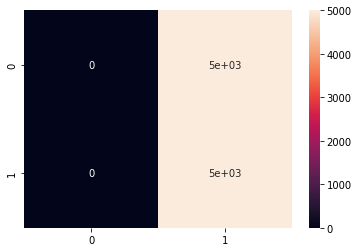

In [ ]:
with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  confusionMatrix = confusion_matrix(np.array(testing_data.labels), np.array(predections))
  print(classification_report(np.array(testing_data.labels), np.array(predections)))
  df = pd.DataFrame(confusionMatrix)
  sns.heatmap(df, annot=True)

## Learning Rate = 10^-2

### **Dataloader and Optimizer Setup**

In [ ]:
from transformers import BertModel

In [ ]:
validation_data = IMDBDataset(inputIdsValidation, AMValidation, y_validation2)
training_data = IMDBDataset(inputIdsTrain, AMTrain, y_train2)
testing_data = IMDBDataset(inputIdsTest, AMTest, y_test2)

INIT_LR = 1e-2
BATCH_SIZE = 16
# EPOCHS = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainDataLoader = DataLoader(training_data, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(validation_data, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testing_data, batch_size=BATCH_SIZE)

trainNumOfBatches = len(trainDataLoader.dataset) // BATCH_SIZE
valNumOfBatches = len(valDataLoader.dataset) // BATCH_SIZE

In [ ]:
PATH = '/content/gdrive/MyDrive/IMDB/Models/FirstModel_2LR_5Epochs.pt'
model = ModifiedBERT()
model.load_state_dict(torch.load(PATH))
model.to(device)
opt = Adam(model.parameters(), lr=INIT_LR, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=0, factor=.1, threshold=1e-4, verbose=True)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### **Training & Testing**

**Training & Validation**

In [ ]:
trainLoss = np.load("/content/gdrive/MyDrive/IMDB/Validation Acc/TrainLoss_2LR_5Epochs.npy")
validationLoss = np.load("/content/gdrive/MyDrive/IMDB/Validation Acc/ValLoss_2LR_5Epochs.npy")
trainAcc = np.load("/content/gdrive/MyDrive/IMDB/Validation Acc/TrainAcc_2LR_5Epochs.npy")
validationAcc = np.load("/content/gdrive/MyDrive/IMDB/Validation Acc/ValAcc_2LR_5Epochs.npy")

for e in range(3,5):
  print('Epoch {0}/{1}'.format(e+1,5))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  trainLoss = np.append(trainLoss, avgTrainLoss.item()*100)
  trainAcc = np.append(trainAcc, correctPred/len(trainDataLoader.dataset))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    validationLoss = np.append(validationLoss, avgValLoss.item()*100)
    validationAcc = np.append(validationAcc, correctPred/len(valDataLoader.dataset))
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  # scheduler.step(avgValLoss)
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/MODTrainAcc_2LR_5Epochs", np.array(trainAcc))
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/MODValLoss_2LR_5Epochs", np.array(validationLoss))
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/MODTrainLoss_2LR_5Epochs", np.array(trainLoss))
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/MODValAcc_2LR_5Epochs", np.array(validationAcc))

  torch.save(model.state_dict(), PATH)
Plotting(trainLoss,trainAcc, validationLoss, validationAcc)

Epoch 4/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss: 0.693827, Train accuracy: 0.5004
Validation loss: 0.693294, Validation accuracy: 0.5000
Epoch 5/5
Train loss: 0.693521, Train accuracy: 0.5017
Validation loss: 0.693162, Validation accuracy: 0.5000


**Testing**


Testing:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificatio

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67      5000
         1.0       0.00      0.00      0.00      5000

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



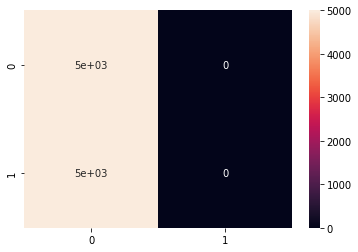

In [ ]:
with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  confusionMatrix = confusion_matrix(np.array(testing_data.labels), np.array(predections))
  print(classification_report(np.array(testing_data.labels), np.array(predections)))
  df = pd.DataFrame(confusionMatrix)
  sns.heatmap(df, annot=True)

# Multiple Learning Rates with Validation Accuracy Plot

In [ ]:
validationAcc6 = np.load("/content/gdrive/MyDrive/IMDB/Validation Acc/ValAcc_6LR_5Epochs.npy",allow_pickle=True)
validationAcc5 = np.load("/content/gdrive/MyDrive/IMDB/Validation Acc/ValAcc_5LR_5Epochs.npy",allow_pickle=True)
validationAcc4 = np.load("/content/gdrive/MyDrive/IMDB/Validation Acc/MODValAcc_4LR_5Epochs.npy",allow_pickle=True)
validationAcc2 = np.load("/content/gdrive/MyDrive/IMDB/Validation Acc/MODValAcc_2LR_5Epochs.npy",allow_pickle=True)

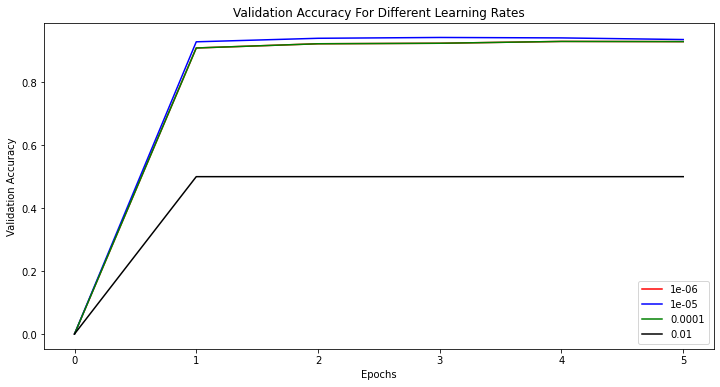

In [ ]:
plotting_learning_rates(validationAcc6, validationAcc5, validationAcc6, validationAcc2, 1e-6, 1e-5, 1e-4, 1e-2)

# Trying Different Models

## Learning Rate = 10^-5

In [ ]:
class ModifiedBERT(nn.Module):
 def __init__(self):
    super(ModifiedBERT, self).__init__()
    
    self.fc1 = nn.Linear(in_features=768, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fcx = nn.Linear(in_features=256, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=128)
    self.fc4 = nn.Linear(in_features=128, out_features=64)
    self.fc5 = nn.Linear(in_features=64, out_features=1)
    self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions = False, output_hidden_states = False) 


 def forward(self, input_ids, input_masks):
    x = self.bert(input_ids, token_type_ids=None, attention_mask=input_masks)[1]
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fcx(x))
    x = F.dropout(x, 0.4)
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))

    return F.sigmoid(self.fc5(x))

In [ ]:
trainLoss = []
validationLoss = []
trainAcc = []
validationAcc = []

print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  trainLoss.append(avgTrainLoss.item()*100)
  trainAcc.append(correctPred/len(trainDataLoader.dataset))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    validationLoss.append(avgValLoss.item()*100)
    validationAcc.append(correctPred/len(valDataLoader.dataset))
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  scheduler.step(avgValLoss)
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/MODTrainAcc_5LR_5Epochs", np.array(trainAcc))
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/MODValLoss_5LR_5Epochs", np.array(validationLoss))
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/MODTrainLoss_5LR_5Epochs", np.array(trainLoss))
  np.save("/content/gdrive/MyDrive/IMDB/Validation Acc/MODValAcc_5LR_5Epochs", np.array(validationAcc))

  torch.save(model.state_dict(), PATH)
Plotting(trainLoss,trainAcc, validationLoss, validationAcc)

Training Model
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss: 0.427488, Train accuracy: 0.7968
Validation loss: 0.273060, Validation accuracy: 0.9016
Epoch 2/5
Train loss: 0.288287, Train accuracy: 0.8881
Validation loss: 0.290769, Validation accuracy: 0.8896
Epoch 00002: reducing learning rate of group 0 to 1.0000e-06.
Epoch 3/5
Train loss: 0.241345, Train accuracy: 0.9103
Validation loss: 0.296627, Validation accuracy: 0.8894
Epoch 00003: reducing learning rate of group 0 to 1.0000e-07.
Epoch 4/5


## Learning Rate = 10^-6

In [ ]:
class ModifiedBERT(nn.Module):
 def __init__(self):
    super(ModifiedBERT, self).__init__()
    
    self.fc1 = nn.Linear(in_features=768, out_features=1024)
    self.fcy = nn.Linear(in_features=1024, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=512)
    self.batchnorm1 = nn.BatchNorm1d(512)
    self.fcc = nn.Linear(in_features=512, out_features=256)
    self.fcx = nn.Linear(in_features=256, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=128)
    self.fc4 = nn.Linear(in_features=128, out_features=64)
    self.fc5 = nn.Linear(in_features=64, out_features=1)
    self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions = False, output_hidden_states = False) 


 def forward(self, input_ids, input_masks):
    x = self.bert(input_ids, token_type_ids=None, attention_mask=input_masks)[1]
    x = F.relu(self.fc1(x))
    x = F.relu(self.fcy(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.batchnorm1(x))
    x = F.relu(self.fcc(x))
    x = F.relu(self.fcx(x))
    x = F.dropout(x, 0.4)
    x = F.relu(self.fc3(x))
    x = F.dropout(x, 0.5)
    x = F.relu(self.fc4(x))

    return F.sigmoid(self.fc5(x))

In [ ]:
trainLoss = []
validationLoss = []
trainAcc = []
validationAcc = []

print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  trainLoss.append(avgTrainLoss.item()*100)
  trainAcc.append(correctPred/len(trainDataLoader.dataset))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    validationLoss.append(avgValLoss.item()*100)
    validationAcc.append(correctPred/len(valDataLoader.dataset))
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  scheduler.step(avgValLoss)

Plotting(trainLoss,trainAcc, validationLoss, validationAcc)

Training Model
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss: 0.692564, Train accuracy: 0.5042
Validation loss: 0.692773, Validation accuracy: 0.5090
Epoch 2/5
Train loss: 0.691759, Train accuracy: 0.5078
Validation loss: 0.691012, Validation accuracy: 0.5340
Epoch 3/5
Train loss: 0.689578, Train accuracy: 0.5268
Validation loss: 0.687351, Validation accuracy: 0.5880
Epoch 4/5
Train loss: 0.684582, Train accuracy: 0.5992
Validation loss: 0.678742, Validation accuracy: 0.7170
Epoch 5/5
Train loss: 0.676274, Train accuracy: 0.6905
Validation loss: 0.668683, Validation accuracy: 0.7960


## Learning Rate = 10^-6

In [ ]:
class ModifiedBERT(nn.Module):
 def __init__(self):
    super(ModifiedBERT, self).__init__()
    
    self.fc1 = nn.Linear(in_features=768, out_features=1024)
    self.fcy = nn.Linear(in_features=1024, out_features=512)
    self.batchnorm1 = nn.BatchNorm1d(512)
    self.fcc = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=128)
    self.fc4 = nn.Linear(in_features=128, out_features=64)
    self.fc6 = nn.Linear(in_features=64, out_features=16)
    self.fc5 = nn.Linear(in_features=16, out_features=1)
    self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions = False, output_hidden_states = False) 


 def forward(self, input_ids, input_masks):
    x = self.bert(input_ids, token_type_ids=None, attention_mask=input_masks)[1]
    x = F.relu(self.fc1(x))
    x = F.relu(self.fcy(x))
    x = F.relu(self.batchnorm1(x))
    x = F.relu(self.fcc(x))
    x = F.dropout(x, 0.5)
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc6(x))

    return F.sigmoid(self.fc5(x))

In [ ]:
trainLoss = []
validationLoss = []
trainAcc = []
validationAcc = []

print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  trainLoss.append(avgTrainLoss.item()*100)
  trainAcc.append(correctPred/len(trainDataLoader.dataset))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    validationLoss.append(avgValLoss.item()*100)
    validationAcc.append(correctPred/len(valDataLoader.dataset))
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  scheduler.step(avgValLoss)

Plotting(trainLoss,trainAcc, validationLoss, validationAcc)

Training Model
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss: 0.701723, Train accuracy: 0.5000
Validation loss: 0.701633, Validation accuracy: 0.5000
Epoch 2/5
Train loss: 0.701205, Train accuracy: 0.5000
Validation loss: 0.700912, Validation accuracy: 0.5000
Epoch 3/5


KeyboardInterrupt: ignored

## Learning Rate = 10^-6

In [ ]:
class ModifiedBERT(nn.Module):
 def __init__(self):
    super(ModifiedBERT, self).__init__()
    
    self.fc1 = nn.Linear(in_features=768, out_features=256)
    self.fc2 = nn.Linear(in_features=256, out_features=64)
    self.fc3 = nn.Linear(in_features=64, out_features=1)
    self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions = False, output_hidden_states = False) 


 def forward(self, input_ids, input_masks):
    x = self.bert(input_ids, token_type_ids=None, attention_mask=input_masks)[1]
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    return F.sigmoid(self.fc3(x))

In [ ]:
trainLoss = []
validationLoss = []
trainAcc = []
validationAcc = []

print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  trainLoss.append(avgTrainLoss.item()*100)
  trainAcc.append(correctPred/len(trainDataLoader.dataset))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    validationLoss.append(avgValLoss.item()*100)
    validationAcc.append(correctPred/len(valDataLoader.dataset))
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  scheduler.step(avgValLoss)

Plotting(trainLoss,trainAcc, validationLoss, validationAcc)

Training Model
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



Train loss: 0.690349, Train accuracy: 0.5717
Validation loss: 0.682491, Validation accuracy: 0.7420
Epoch 2/5
Train loss: 0.651962, Train accuracy: 0.8017
Validation loss: 0.597149, Validation accuracy: 0.8710
Epoch 3/5
Train loss: 0.546060, Train accuracy: 0.8895
Validation loss: 0.490727, Validation accuracy: 0.8950
Epoch 4/5
Train loss: 0.456369, Train accuracy: 0.9087
Validation loss: 0.424057, Validation accuracy: 0.9000
Epoch 5/5
Train loss: 0.388551, Train accuracy: 0.9245
Validation loss: 0.376640, Validation accuracy: 0.9090


## Learning Rate = 10^-6

In [ ]:
class ModifiedBERT(nn.Module):
 def __init__(self):
    super(ModifiedBERT, self).__init__()
    
    self.fc1 = nn.Linear(in_features=768, out_features=64)
    self.fcy = nn.Linear(in_features=64, out_features=16)
    self.fc5 = nn.Linear(in_features=16, out_features=1)
    self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions = False, output_hidden_states = False) 


 def forward(self, input_ids, input_masks):
    x = self.bert(input_ids, token_type_ids=None, attention_mask=input_masks)[1]
    x = F.relu(self.fc1(x))
    x = F.relu(self.fcy(x))
    return F.sigmoid(self.fc5(x))

In [ ]:
trainLoss = []
validationLoss = []
trainAcc = []
validationAcc = []

print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  trainLoss.append(avgTrainLoss.item()*100)
  trainAcc.append(correctPred/len(trainDataLoader.dataset))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    validationLoss.append(avgValLoss.item()*100)
    validationAcc.append(correctPred/len(valDataLoader.dataset))
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  scheduler.step(avgValLoss)

Plotting(trainLoss,trainAcc, validationLoss, validationAcc)

Training Model
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss: 0.690377, Train accuracy: 0.5427
Validation loss: 0.684645, Validation accuracy: 0.7080
Epoch 2/5
Train loss: 0.671551, Train accuracy: 0.7475
Validation loss: 0.646259, Validation accuracy: 0.8540
Epoch 3/5
